In [26]:
import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # for CUDA deterministic (can slow training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [27]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [28]:
print(df.isna().sum()[df.isna().sum() > 0])

Series([], dtype: int64)


In [29]:
label_col = 'Cover_Type'

In [30]:
if label_col not in df.columns:
    raise ValueError(f"Label column '{label_col}' not found. Columns: {df.columns.tolist()[:20]}")

In [31]:
nan_labels = df[label_col].isna().sum()
print("NaN labels count:", nan_labels)

NaN labels count: 0


In [32]:
if nan_labels > 0:
    print("Dropping rows with NaN labels.")
    df = df[~df[label_col].isna()].copy()


In [33]:
nan_features = df.isna().any(axis=1).sum()
print("Rows with any NaN feature:", nan_features)
if nan_features > 0:
    print("Dropping rows with NaN features.")
    df = df.dropna()


Rows with any NaN feature: 0


In [34]:
X = df.drop(columns=[label_col]).values
y = df[label_col].values.astype(int)  # labels expected 1..7 in this dataset
# convert labels to 0..K-1 for PyTorch
classes = np.unique(y)
print("Unique cover types:", classes)
label_map = {c: i for i, c in enumerate(sorted(classes))}
y = np.array([label_map[v] for v in y])
num_classes = len(np.unique(y))
print("num_classes:", num_classes)

Unique cover types: [1 2 3 4 5 6 7]
num_classes: 7


In [35]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.17647, random_state=42, stratify=y_train_full
)
# 0.17647 * 0.85 ≈ 0.15, so final splits: 70% train, 15% val, 15% test

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (406708, 54) Val: (87152, 54) Test: (87152, 54)


In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [37]:
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)

batch_size = 1024
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=batch_size, shuffle=False)


In [38]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("class_weights:", class_weights)

# === Build a deeper MLP (improved) ===
input_dim = X_train_scaled.shape[1]

class DeepMLP(nn.Module):
    def __init__(self, input_dim, num_classes, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(64, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

model = DeepMLP(input_dim=input_dim, num_classes=num_classes, dropout=0.25).to(device)
print(model)

class_weights: tensor([ 0.3918,  0.2930,  2.3214, 30.2138,  8.7436,  4.7792,  4.0472])
DeepMLP(
  (net): Sequential(
    (0): Linear(in_features=54, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.25, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.25, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.25, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.25, inplace=False)
    (16): Linear(in_features=64, out_features=7,

In [41]:
criterion = nn.CrossEntropyLoss(weight=class_weights)  # class-weighted
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# === Training loop with early stopping ===
from tqdm import tqdm

def evaluate(model, loader, device):
    model.eval()
    ys, yp = [], []
    loss_accum = 0.0
    n = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            loss_accum += float(loss.item()) * xb.size(0)
            n += xb.size(0)
            preds = logits.argmax(dim=1).cpu().numpy()
            ys.append(yb.cpu().numpy())
            yp.append(preds)
    ys = np.concatenate(ys)
    yp = np.concatenate(yp)
    avg_loss = loss_accum / n
    acc = accuracy_score(ys, yp)
    return avg_loss, acc, ys, yp


In [45]:
num_epochs = 80
best_val_acc = 0.0
best_model_state = None
patience = 6
counter = 0

history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for epoch in range(1, num_epochs+1):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}", leave=False)
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
        pbar.set_postfix({'loss': f"{loss.item():.4f}"})

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

    # early stopping based on val_acc
    if val_acc > best_val_acc + 1e-5:
        best_val_acc = val_acc
        best_model_state = {k: v.cpu() for k,v in model.state_dict().items()}
        counter = 0
        print("  New best model saved.")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered (patience={patience}).")
            break

# Restore best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Save model
torch.save(model.state_dict(), "/content/best_deep_mlp.pth")
print("Best val acc:", best_val_acc)

Epoch 1: Train Loss=0.2821, Train Acc=0.8120, Val Loss=0.2291, Val Acc=0.8444
  New best model saved.


Epoch 2: Train Loss=0.2841, Train Acc=0.8118, Val Loss=0.2198, Val Acc=0.8438


Epoch 3: Train Loss=0.2827, Train Acc=0.8124, Val Loss=0.2197, Val Acc=0.8438


Epoch 4: Train Loss=0.2789, Train Acc=0.8138, Val Loss=0.2163, Val Acc=0.8476
  New best model saved.


Epoch 5: Train Loss=0.2755, Train Acc=0.8160, Val Loss=0.2184, Val Acc=0.8470


Epoch 6: Train Loss=0.2764, Train Acc=0.8139, Val Loss=0.2149, Val Acc=0.8482
  New best model saved.


Epoch 7: Train Loss=0.2763, Train Acc=0.8163, Val Loss=0.2136, Val Acc=0.8476


Epoch 8: Train Loss=0.2768, Train Acc=0.8166, Val Loss=0.2195, Val Acc=0.8449


Epoch 9: Train Loss=0.2777, Train Acc=0.8167, Val Loss=0.2199, Val Acc=0.8481


Epoch 10: Train Loss=0.2712, Train Acc=0.8174, Val Loss=0.2142, Val Acc=0.8487
  New best model saved.


Epoch 11: Train Loss=0.2710, Train Acc=0.8185, Val Loss=0.2139, Val Acc=0.8442


Epoch 12: Train Loss=0.2586, Train Acc=0.8226, Val Loss=0.2001, Val Acc=0.8583
  New best model saved.


Epoch 13: Train Loss=0.2502, Train Acc=0.8279, Val Loss=0.1951, Val Acc=0.8580


Epoch 14: Train Loss=0.2473, Train Acc=0.8292, Val Loss=0.1935, Val Acc=0.8598
  New best model saved.


Epoch 15: Train Loss=0.2457, Train Acc=0.8293, Val Loss=0.1957, Val Acc=0.8589


Epoch 16: Train Loss=0.2483, Train Acc=0.8295, Val Loss=0.1934, Val Acc=0.8605
  New best model saved.


Epoch 17: Train Loss=0.2433, Train Acc=0.8305, Val Loss=0.1956, Val Acc=0.8583


Epoch 18: Train Loss=0.2446, Train Acc=0.8310, Val Loss=0.1903, Val Acc=0.8602


Epoch 19: Train Loss=0.2435, Train Acc=0.8316, Val Loss=0.1904, Val Acc=0.8624
  New best model saved.


Epoch 20: Train Loss=0.2392, Train Acc=0.8335, Val Loss=0.1887, Val Acc=0.8628
  New best model saved.


Epoch 21: Train Loss=0.2400, Train Acc=0.8336, Val Loss=0.1893, Val Acc=0.8639
  New best model saved.


Epoch 22: Train Loss=0.2407, Train Acc=0.8337, Val Loss=0.1884, Val Acc=0.8643
  New best model saved.


Epoch 23: Train Loss=0.2387, Train Acc=0.8332, Val Loss=0.1874, Val Acc=0.8641


Epoch 24: Train Loss=0.2365, Train Acc=0.8348, Val Loss=0.1844, Val Acc=0.8666
  New best model saved.


Epoch 25: Train Loss=0.2372, Train Acc=0.8352, Val Loss=0.1858, Val Acc=0.8623


Epoch 26: Train Loss=0.2356, Train Acc=0.8349, Val Loss=0.1842, Val Acc=0.8655


Epoch 27: Train Loss=0.2362, Train Acc=0.8348, Val Loss=0.1817, Val Acc=0.8677
  New best model saved.


Epoch 28: Train Loss=0.2370, Train Acc=0.8358, Val Loss=0.1867, Val Acc=0.8645


Epoch 29: Train Loss=0.2337, Train Acc=0.8364, Val Loss=0.1839, Val Acc=0.8653


Epoch 30: Train Loss=0.2337, Train Acc=0.8369, Val Loss=0.1808, Val Acc=0.8667


Epoch 31: Train Loss=0.2300, Train Acc=0.8378, Val Loss=0.1822, Val Acc=0.8662


Epoch 32: Train Loss=0.2318, Train Acc=0.8376, Val Loss=0.1856, Val Acc=0.8688
  New best model saved.


Epoch 33: Train Loss=0.2331, Train Acc=0.8382, Val Loss=0.1831, Val Acc=0.8663


Epoch 34: Train Loss=0.2313, Train Acc=0.8377, Val Loss=0.1821, Val Acc=0.8687


Epoch 35: Train Loss=0.2240, Train Acc=0.8409, Val Loss=0.1749, Val Acc=0.8730
  New best model saved.


Epoch 36: Train Loss=0.2206, Train Acc=0.8420, Val Loss=0.1755, Val Acc=0.8694


Epoch 37: Train Loss=0.2197, Train Acc=0.8434, Val Loss=0.1740, Val Acc=0.8721


Epoch 38: Train Loss=0.2188, Train Acc=0.8435, Val Loss=0.1746, Val Acc=0.8719


Epoch 39: Train Loss=0.2201, Train Acc=0.8431, Val Loss=0.1749, Val Acc=0.8700


Epoch 40: Train Loss=0.2192, Train Acc=0.8435, Val Loss=0.1712, Val Acc=0.8745
  New best model saved.


Epoch 41: Train Loss=0.2174, Train Acc=0.8446, Val Loss=0.1729, Val Acc=0.8747
  New best model saved.


Epoch 42: Train Loss=0.2152, Train Acc=0.8453, Val Loss=0.1698, Val Acc=0.8757
  New best model saved.


Epoch 43: Train Loss=0.2180, Train Acc=0.8447, Val Loss=0.1714, Val Acc=0.8746


Epoch 44: Train Loss=0.2163, Train Acc=0.8443, Val Loss=0.1715, Val Acc=0.8740


Epoch 45: Train Loss=0.2146, Train Acc=0.8453, Val Loss=0.1695, Val Acc=0.8760
  New best model saved.


Epoch 46: Train Loss=0.2162, Train Acc=0.8452, Val Loss=0.1694, Val Acc=0.8740


Epoch 47: Train Loss=0.2147, Train Acc=0.8460, Val Loss=0.1685, Val Acc=0.8779
  New best model saved.


Epoch 48: Train Loss=0.2141, Train Acc=0.8458, Val Loss=0.1685, Val Acc=0.8743


Epoch 49: Train Loss=0.2110, Train Acc=0.8472, Val Loss=0.1680, Val Acc=0.8755


Epoch 50: Train Loss=0.2148, Train Acc=0.8466, Val Loss=0.1681, Val Acc=0.8755


Epoch 51: Train Loss=0.2120, Train Acc=0.8485, Val Loss=0.1670, Val Acc=0.8771


Epoch 52: Train Loss=0.2109, Train Acc=0.8480, Val Loss=0.1647, Val Acc=0.8789
  New best model saved.


Epoch 53: Train Loss=0.2104, Train Acc=0.8486, Val Loss=0.1678, Val Acc=0.8774


Epoch 54: Train Loss=0.2110, Train Acc=0.8477, Val Loss=0.1687, Val Acc=0.8753


Epoch 55: Train Loss=0.2134, Train Acc=0.8483, Val Loss=0.1663, Val Acc=0.8765


Epoch 56: Train Loss=0.2119, Train Acc=0.8483, Val Loss=0.1669, Val Acc=0.8776


Epoch 57: Train Loss=0.2091, Train Acc=0.8489, Val Loss=0.1665, Val Acc=0.8754


Epoch 58: Train Loss=0.2067, Train Acc=0.8494, Val Loss=0.1636, Val Acc=0.8781
Early stopping triggered (patience=6).
Best val acc: 0.8788668074169268


Test loss: 0.1679307387956068 Test acc: 0.8783160455296494
Classification report (test):
              precision    recall  f1-score   support

           0     0.9045    0.8685    0.8861     31776
           1     0.9197    0.8635    0.8907     42495
           2     0.8896    0.9181    0.9037      5363
           3     0.6672    0.9927    0.7980       412
           4     0.4179    0.9923    0.5881      1424
           5     0.7607    0.9386    0.8404      2605
           6     0.7658    0.9968    0.8661      3077

    accuracy                         0.8783     87152
   macro avg     0.7608    0.9386    0.8247     87152
weighted avg     0.8928    0.8783    0.8821     87152



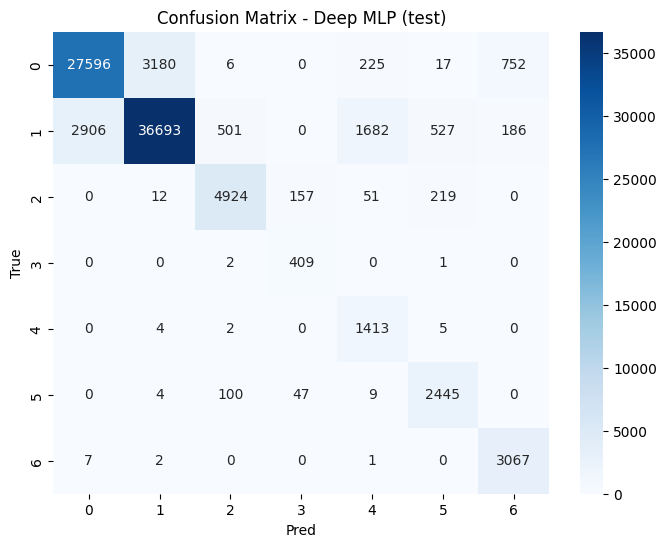

Precision (macro): 0.7607902906304723
Recall (macro): 0.938626680453032
F1 (macro): 0.8247376306035802


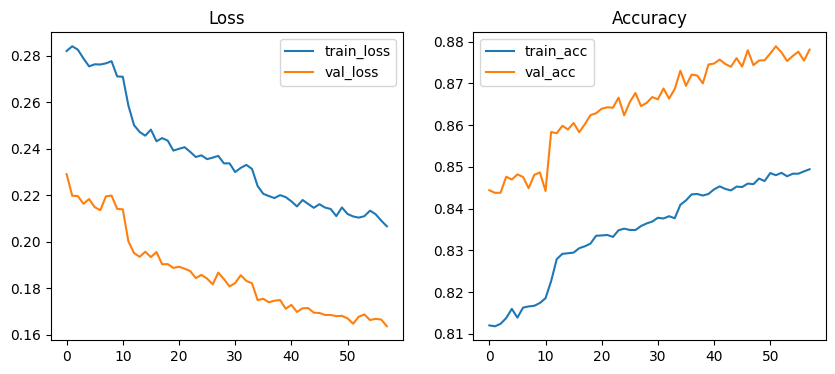

Saved model and history to /content


In [46]:
test_loss, test_acc, y_true, y_pred = evaluate(model, test_loader, device)
print("Test loss:", test_loss, "Test acc:", test_acc)

print("Classification report (test):")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Deep MLP (test)")
plt.ylabel("True")
plt.xlabel("Pred")
plt.show()

# Compute macro metrics explicitly
precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
print("Precision (macro):", precision_macro)
print("Recall (macro):", recall_macro)
print("F1 (macro):", f1_macro)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# Save train history
import pickle
with open('/content/train_history.pkl', 'wb') as f:
    pickle.dump(history, f)

print("Saved model and history to /content")